# Calibrating the Ion Trap 

To calibrate the ion trap the following set of equations are required. 

We begin by loading the reference files 


In [11]:
#Importing Libraries
import pandas as pd
import numpy as np 
from sympy import *
import matplotlib.pyplot as plt
from scipy import signal
import os

#Custom classes/functions 
import linearfittings as lf
import iontrap_functions as iontrap
import EBC_functions as ebc



In [2]:
data_date = '20220921'
data_directory = '/home/levitech/millen2/ElectroMech/Data/' + data_date
#Calibration filename
calfilename = '/home/levitech/millen2/ElectroMech/Data/20220921/20220921_calibrationdata.csv'

#Reference Filename
reffilename = '/home/levitech/millen2/ElectroMech/Data/20220921/20220921_reftable.csv'

#Simulation Geometric Parameter Filename
simPar = '/home/levitech/millen2/PythonLibrary/SimGeometricFactors.csv'

# Reading the csv files.
caltable = pd.read_csv(calfilename)
reftable = pd.read_csv(reffilename)
simpara = pd.read_csv(simPar)


From reference table we have some of the values we can use for extracting the Q/M values. Recall that 

$\omega_i^2 = \left(\alpha_i^2\frac{V^2}{2 \omega_D^2 r^4}(\frac{Q}{M})_i^2 + \beta_i\frac{2U}{d^2}(\frac{Q}{M})_i\right)$

where  $i \in \{x,y,z\}$ and refers to the x,y,z secular frequencies of the particle. The above can also be written as: 

$c = aq^2 + bq$

where $q = (Q/M)$ and $a$ and $b$ are the coefficient $(Q/M)_i$. This also forms 3 simultaneous equations which therefore can be solved to work out charge-mass ratio, $q_i$



In [3]:
# Declaring the symbolic variables
a, b, c, x = symbols('a, b, c, x',real=True)

# Defining the equation that needs to be solved
eqn = a*x**2 + b*x - c;

# creater the solver
xSol = solveset(eqn,x)
xSol

{-b/(2*a) - sqrt(4*a*c + b**2)/(2*a), -b/(2*a) + sqrt(4*a*c + b**2)/(2*a)}

Above is the the x solution to the quadratic equation in terms of Q/M. We load and prepare the experimental parameters that need to go in to the a,b,c parameters 

In [4]:
# The Driving frequency in radians
wD = 2*np.pi*reftable.Freq_RF

# The secular frequencies in radians
w0 = 2*np.pi*(pd.concat([reftable.fx,reftable.fy,reftable.fz],ignore_index=True))

# determining the coefficients to the quadratic equation 
aa = (simpara.alpha**2)*((reftable.V0**2)/(2*wD**2*reftable.R**4)).values
bb = (simpara.beta)*((2*reftable.U0)/(reftable.Z0**2)).values
cc = w0**2

# Solving for x in x y and z dimensions
sol_x = list(xSol.subs([(a,aa[0]),(b,bb[0]),(c,cc[0])]))
sol_y = list(xSol.subs([(a,aa[1]),(b,bb[1]),(c,cc[1])]))
sol_z = list(xSol.subs([(a,aa[2]),(b,bb[2]),(c,cc[2])]))

# charge mass ration calculated based on x y and z motional dynamics
QM = pd.DataFrame( {'qm_x': sol_x,
               'qm_y': sol_y,
               'qm_z': sol_z })

print(QM)

                  qm_x                 qm_y                 qm_z
0  -0.0240462715889732  -0.0226856155943916  -0.0139022057697716
1   0.0195079112120602   0.0209392637618616   0.0152266045277825


The above can also be all wrapped up in a set of functions getQM(), which can be obtained from the iontrap_functions module 

In [5]:
# Call the class module ion trap, 
iontrap.getQM(reftable,simpara)

,qm_x,qm_y,qm_z
0,-0.0240462715889732,-0.0226856155943916,-0.0139022057697716
1,0.0195079112120602,0.0209392637618616,0.0152266045277825


There invariable are two solutions to the charge-mass ratio. Which one is correct since in principle both the charge mass ratio can be negative and positive? 

## Obtaining the calibration factor 

To build the calibration factor, the ion trap endcaps apply a voltage shift $\Delta V$ which is non-zero. This results in a force on the particle and this a displacement ideally along the endcap directions. 

$ \Delta x[\text{metres}] \eta = \Delta x[\text{pixels}]  = \eta \frac{Q}{M}\frac{\Delta V}{\omega_0^2 d}$ 

where $\Delta x $ is the distance the particle moves due to an applied voltage difference of $\Delta V$. The distance between the endcap electrodes is given by $d$ and the secular frequency between the endcaps is $\omega_0$. the $\eta$ is the conversion parameter converting the measured signal in pixels or volts (depending on the detector being used) to metres. $\eta$ has the units of $[\text{pixels}/\text{metre}]$

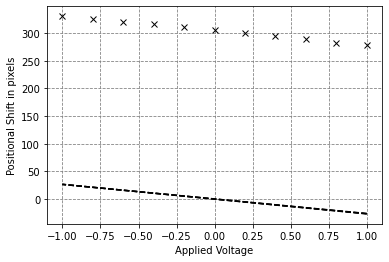

In [50]:
# if calibration table already exists. then we call that table. 

x = caltable['meanX']
w_x = caltable['stdX']
y = caltable['meanY']
w_y = caltable['stdY']
v = caltable['diff']
vInMetres = v

xFit = lf.linearfittings(v,x-np.mean(x),w_x)

# In principle the same fitting class can be used for determining
# fitting to any y = a*X + b equation

yFit = lf.linearfittings(v,y,w_x)

fig, ax = plt.subplots()
ax.plot(v,x, "xk")
ax.plot(xFit.x, xFit.fitfunc, '--k')
ax.plot(xFit.x, xFit.errorfunc, '--k')#
plt.xlabel('Applied Voltage')
plt.ylabel('Positional Shift in pixels')
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.show()

In [49]:
xFit.coef

array([-26.52363636, 304.83181818])

Now that a value is obtained for the gradient of the fitted line, $g$. This corresponds to conversation factor pixels per metre, $\eta = (1/qm)*\omega_0^2*d*g$.



In [28]:
# check if the reference file exists and is named correctly
# if not reftable['ReferenceSave'][0][0:8] == data_date:
#     print('the date in ReferenceSave is not the same as the date the data was taken. Please rectify.')
    
# reference file name
reference_folder = data_directory + '/' + reftable['ReferenceSave'][0] + '/'
# print(reference_folder)

import pandas as pd

dataDir = pd.DataFrame(os.listdir(reference_folder), columns=['filename'])
dataDir['folder'] = reference_folder

X = pd.DataFrame(columns=['0'])

for idx, path in enumerate(dataDir['folder'] + dataDir['filename']):
    print('loading ', dataDir.filename[idx])
    filename = dataDir.filename[idx]
    datatable = ebc.Read_CSV(path) 
    ID = ebc.get_modeID(datatable)
    x,  y, time = ebc.getXYtime(ebc.filter_DataTable_By_ID(datatable,ID[0]))
    X[filename] = x/ 
#     print(x)
    

loading  20220921_14-23-11.csv
loading  20220921_14-26-27.csv
loading  20220921_14-21-59.csv
loading  20220921_14-22-45.csv
loading  20220921_14-24-24.csv
loading  20220921_14-07-49.csv
loading  20220921_14-25-15.csv
loading  20220921_14-08-47.csv
loading  20220921_14-22-22.csv
loading  20220921_14-24-50.csv
loading  20220921_14-25-39.csv
loading  20220921_14-08-17.csv
loading  20220921_14-23-38.csv


Text(0.5, 0, 'Frequency, $\\omega/2\\pi$ (Hz)')

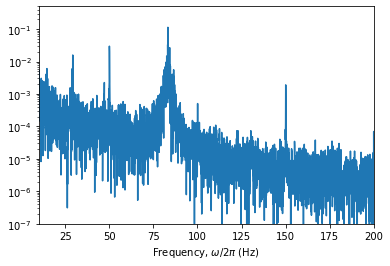

In [47]:
fs = 1/time.diff().mode().values
f, pxx = signal.periodogram(x,fs)


plt.semilogy(f,pxx)
plt.xlim(10,200)
plt.ylim(1e-7,5e-1)
plt.xlabel('Frequency, $\omega/2\pi$ (Hz)')
plt.ylabel('S_xx($\omega/2\pi$) ')



In [35]:
time.diff().mode().values

array([0.001])